In [1]:
# =========================
# Install all required libraries for this project
# =========================
!pip -q install -U \
  numpy pandas scipy \
  scikit-learn \
  matplotlib \
  tqdm \
  textstat \
  torch \
  transformers \
  datasets \
  accelerate
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import re
import string
from collections import Counter

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re, math, hashlib, zlib
from collections import Counter

import textstat
import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tqdm.pandas()  # enable progress bar on apply

# load lightweight spaCy model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Columns: Index(['text', 'label', 'doc_id', 'source'], dtype='object')
First few rows:


,text,label,doc_id,source
0,The Face in the picture was not created by ali...,0,kaggle_0,kaggle
1,Title: My Dream Career: Becoming a Software En...,1,kaggle_1,kaggle
2,Attending classes at home is not a great benef...,0,kaggle_2,kaggle
3,What's Your Opinion? By: Generic_Name Have you...,0,kaggle_3,kaggle
4,The exploration of nearby planets has always b...,1,kaggle_4,kaggle



Dataset shape: (505254, 4)

Label value counts:
label
0    311712
1    193542
Name: count, dtype: int64


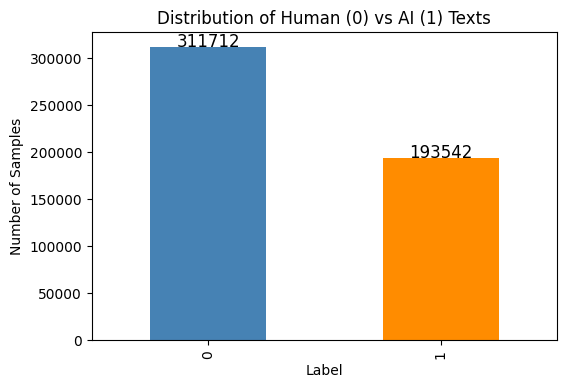

In [3]:
CSV_PATH = "final_merged_dataset.csv"
TEXT_COL = "text"
LABEL_COL = "label"

# Robust CSV load (handles quotes, bad lines)
df = pd.read_csv(
    CSV_PATH,
    engine="python",
    escapechar="\\",
    on_bad_lines="skip"
)

# Drop rows with missing text/label
df = df.dropna(subset=[TEXT_COL, LABEL_COL]).copy()

# Clean label column: ensure numeric 0/1
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce")
df[LABEL_COL] = df[LABEL_COL].fillna(0).astype(int)

#additional fixes for NAN values
df["source"] = df["source"].fillna("kaggle")
nan_rows = df['doc_id'].isna()
df.loc[nan_rows, 'doc_id'] = "kaggle_" + df.loc[nan_rows].index.astype(str)


print("Columns:", df.columns)
print("First few rows:")
display(df.head())
print(f"\nDataset shape: {df.shape}")

print("\nLabel value counts:")
# Count class distribution
counts = df[LABEL_COL].value_counts().sort_index()
print(counts)


import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['steelblue', 'darkorange'])
plt.title("Distribution of Human (0) vs AI (1) Texts")
plt.xlabel("Label")
plt.ylabel("Number of Samples")

# Annotate bars with counts
for i, v in enumerate(counts):
    plt.text(i, v + 500, str(v), ha='center', fontsize=12)

plt.show()

In [5]:
# =========================
# FINAL FEATURE WRAPPER CELL
# (Does NOT modify your existing features)
# =========================

import re
from typing import Dict

# ---------- helpers ----------
def get_lines(text: str, max_lines: int):
    if not isinstance(text, str) or not text:
        return []
    return text.splitlines()[:max_lines]

def basic_counts(text: str):
    text = text or ""
    num_chars = len(text)

    # sentence split
    sentences = re.split(r"[.!?]+", text)
    sentences = [s.strip() for s in sentences if s.strip()]
    num_sent = len(sentences) if sentences else 1

    # word tokens
    words = re.findall(r"\w+", text)
    num_words = len(words) if words else 1

    avg_sent_len = num_words / num_sent
    return {
        "num_chars": num_chars,
        "num_words": num_words,
        "num_sentences": num_sent,
        "avg_sentence_length": avg_sent_len,
    }


def lexical_diversity(text: str):
    words = re.findall(r"\w+", str(text).lower())
    if not words:
        return {
            "type_token_ratio": 0.0,
            "unique_words": 0,
        }
    unique = set(words)
    ttr = len(unique) / len(words)
    return {
        "type_token_ratio": ttr,
        "unique_words": len(unique),
    }


def punctuation_stats(text: str):
    text = text or ""
    if not text:
        return {
            "pct_punct": 0.0,
            "pct_upper": 0.0,
            "pct_digit": 0.0,
        }
    total = len(text)
    punct = sum(ch in string.punctuation for ch in text)
    upper = sum(ch.isupper() for ch in text)
    digit = sum(ch.isdigit() for ch in text)
    return {
        "pct_punct": punct / total,
        "pct_upper": upper / total,
        "pct_digit": digit / total,
    }


def readability_features(text: str):
    clean = text if isinstance(text, str) else ""
    if len(clean.split()) < 3:
        return {
            "flesch_reading_ease": 0.0,
            "flesch_kincaid_grade": 0.0,
            "gunning_fog": 0.0,
        }
    try:
        fre = textstat.flesch_reading_ease(clean)
        fkg = textstat.flesch_kincaid_grade(clean)
        gf  = textstat.gunning_fog(clean)
    except Exception:
        fre, fkg, gf = 0.0, 0.0, 0.0
    return {
        "flesch_reading_ease": fre,
        "flesch_kincaid_grade": fkg,
        "gunning_fog": gf,
    }


def repetition_features(text: str):
    tokens = re.findall(r"\w+", str(text).lower())
    if len(tokens) < 4:
        return {"bigram_repetition_ratio": 0.0}
    bigrams = list(zip(tokens, tokens[1:]))
    total_bigrams = len(bigrams)
    counts = Counter(bigrams)
    repeated = sum(c for c in counts.values() if c > 1)
    return {
        "bigram_repetition_ratio": repeated / total_bigrams
    }


def pos_features_spacy(text: str):
    doc = nlp(str(text))
    tokens = [t for t in doc if not t.is_space]
    total_tokens = len(tokens)
    if total_tokens == 0:
        return {
            "pos_ratio_NOUN": 0.0,
            "pos_ratio_VERB": 0.0,
            "pos_ratio_ADJ": 0.0,
            "pos_ratio_ADV": 0.0,
            "pos_ratio_PRON": 0.0,
            "pos_ratio_ADP": 0.0,
            "pos_ratio_DET": 0.0,
        }
    counts = Counter(tok.pos_ for tok in tokens)

    def ratio(tag):
        return counts.get(tag, 0) / total_tokens

    return {
        "pos_ratio_NOUN": ratio("NOUN"),
        "pos_ratio_VERB": ratio("VERB"),
        "pos_ratio_ADJ":  ratio("ADJ"),
        "pos_ratio_ADV":  ratio("ADV"),
        "pos_ratio_PRON": ratio("PRON"),
        "pos_ratio_ADP":  ratio("ADP"),
        "pos_ratio_DET":  ratio("DET"),
    }


def sentence_length_stats(text: str):
    sentences = re.split(r"[.!?]+", str(text))
    sentences = [s.strip() for s in sentences if s.strip()]
    if len(sentences) < 2:
        return {
            "sentence_length_std": 0.0,
            "sentence_length_mean": len(str(text).split()),
        }
    lens = [len(s.split()) for s in sentences]
    return {
        "sentence_length_std": float(np.std(lens)),
        "sentence_length_mean": float(np.mean(lens)),
    }


def compute_all_features(text: str):
    feats = {}
    feats.update(basic_counts(text))
    feats.update(lexical_diversity(text))
    feats.update(punctuation_stats(text))
    feats.update(readability_features(text))
    feats.update(repetition_features(text))
    feats.update(pos_features_spacy(text))
    feats.update(sentence_length_stats(text))
    return feats

# ============================================================
# NEW FEATURES (ADDITIVE ONLY — your features remain unchanged)
# ============================================================

# --- A) Em-dash / emphasis punctuation ---
def emphasis_punctuation_features(text: str, max_lines: int = 5) -> Dict:
    lines = get_lines(text, max_lines)
    joined = "\n".join(lines)
    n = len(joined) if joined else 1

    return {
        "emdash_ratio": joined.count("—") / n,
        "double_dash_ratio": joined.count("--") / n,
        "colon_ratio_emphasis": joined.count(":") / n,
        "semicolon_ratio_emphasis": joined.count(";") / n,
        "emphasis_punctuation_ratio": (
            joined.count("—")
            + joined.count("--")
            + joined.count(":")
            + joined.count(";")
        ) / n,
    }


# --- B) Hedging / cautious language ---
HEDGE_PHRASES = [
    "some might argue",
    "it could be said",
    "it may be",
    "it might be",
    "it is possible that",
    "it appears that",
    "it seems that",
    "may suggest",
    "could suggest",
    "is often considered",
    "is generally regarded",
]

def hedging_language_features(text: str, max_lines: int = 5) -> Dict:
    lines = get_lines(text.lower(), max_lines)
    if not lines:
        return {
            "hedge_phrase_count": 0,
            "hedge_phrase_ratio": 0.0,
            "hedge_line_ratio": 0.0,
        }

    hedge_count = 0
    hedge_lines = 0

    for ln in lines:
        c = sum(ln.count(p) for p in HEDGE_PHRASES)
        if c > 0:
            hedge_count += c
            hedge_lines += 1

    total = len(lines)

    return {
        "hedge_phrase_count": hedge_count,
        "hedge_phrase_ratio": hedge_count / total,
        "hedge_line_ratio": hedge_lines / total,
    }


# --- C) Vague / hallucination-proxy language ---
GENERIC_CLAIMS = [
    "studies suggest",
    "research shows",
    "experts believe",
    "it is believed",
    "it is widely accepted",
]

VAGUE_QUANTIFIERS = [
    "various",
    "numerous",
    "several",
    "many",
    "a number of",
    "some",
]

FAKE_CITATION_PATTERNS = [
    r"\[\d+\]",        # [1], [23]
    r"\(\d{4}\)",      # (2021)
    r"et al\.",        # et al.
]

def vague_and_hallucination_features(text: str, max_lines: int = 5) -> Dict:
    lines = get_lines(text.lower(), max_lines)
    if not lines:
        return {
            "generic_claim_ratio": 0.0,
            "vague_quantifier_ratio": 0.0,
            "fake_citation_ratio": 0.0,
        }

    generic = 0
    vague = 0
    fake = 0

    for ln in lines:
        if any(p in ln for p in GENERIC_CLAIMS):
            generic += 1
        if any(q in ln for q in VAGUE_QUANTIFIERS):
            vague += 1
        if any(re.search(rx, ln) for rx in FAKE_CITATION_PATTERNS):
            fake += 1

    total = len(lines)

    return {
        "generic_claim_ratio": generic / total,
        "vague_quantifier_ratio": vague / total,
        "fake_citation_ratio": fake / total,
    }


# ============================================================
# FINAL WRAPPER (calls YOUR features + new ones)
# ============================================================

def compute_all_features_final(text: str, max_lines: int = 5) -> Dict:
    feats = {}
    feats.update(basic_counts(text))
    feats.update(lexical_diversity(text))
    feats.update(punctuation_stats(text))
    feats.update(readability_features(text))
    feats.update(repetition_features(text))
    feats.update(pos_features_spacy(text))
    feats.update(sentence_length_stats(text))
    feats.update(emphasis_punctuation_features(text, max_lines))
    feats.update(hedging_language_features(text, max_lines))
    feats.update(vague_and_hallucination_features(text, max_lines))

    return feats


-------------------------
quick sanity check
-------------------------
print(compute_all_features_final(
    "Some might argue — it could be said that research shows various factors.\n[1] et al. (2021)",
    max_lines=5
))

In [14]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

RANDOM_SEED = 42
MAX_LINES_FOR_NEW_FEATURES = 5
SAMPLE_N = 80000               #start here; increase later if needed

# ---- 1) Create a stratified sample (label-balanced + length-bin coverage) ----
# Length binning based on character length tertiles (computed on the full df, but only uses text length)
char_len = df["text"].astype(str).str.len()

q1, q2 = char_len.quantile([1/3, 2/3]).values
length_bin = pd.cut(char_len, bins=[-np.inf, q1, q2, np.inf], labels=["short", "medium", "long"])

# Add a temp bin column (small metadata, OK)
df_tmp = df.copy()
df_tmp["length_bin_tmp"] = length_bin.astype(str)

# Stratify by (label, length_bin)
group_cols = ["label", "length_bin_tmp"]
groups = df_tmp.groupby(group_cols, group_keys=False)

n_groups = groups.ngroups
per_group = SAMPLE_N // n_groups

# Sample per group (balanced across label + bins)
parts = []
for key, g in groups:
    take = min(per_group, len(g))
    parts.append(g.sample(n=take, random_state=RANDOM_SEED))

df_sample = pd.concat(parts, axis=0).sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)

# If rounding left us short, top up with label-stratified sampling
remaining = SAMPLE_N - len(df_sample)
if remaining > 0:
    df_rest = df_tmp.drop(df_sample.index, errors="ignore")
    topup = (
        df_rest.groupby("label", group_keys=False)
        .apply(lambda x: x.sample(n=min(remaining // 2, len(x)), random_state=RANDOM_SEED))
    )
    df_sample = pd.concat([df_sample, topup], axis=0).sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)

# Keep only needed columns (avoid carrying temp column forward)
df_sample = df_sample[["text", "label", "doc_id", "source"]].copy()

print("Sample shape:", df_sample.shape)
print("Label distribution:\n", df_sample["label"].value_counts())
print("Source distribution (top):\n", df_sample["source"].value_counts().head())

#2) Compute features on the sample only
#Returns one dict per row → DataFrame
features_series = df_sample["text"].progress_apply(
    lambda t: compute_all_features_final(t, max_lines=MAX_LINES_FOR_NEW_FEATURES)
)

X_style = pd.DataFrame(list(features_series))

# Optional: cast to float32 to reduce memory
for c in X_style.columns:
    if X_style[c].dtype == "float64":
        X_style[c] = X_style[c].astype("float32")

print("Stylometric feature matrix:", X_style.shape)
display(X_style.head())

/tmp/ipykernel_2319/893950601.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(remaining // 2, len(x)), random_state=RANDOM_SEED))


Sample shape: (80000, 4)
Label distribution:
 label
1    40000
0    40000
Name: count, dtype: int64
Source distribution (top):
 source
kaggle       76770
chatgpt       2511
wikipedia      411
news           200
arxiv          108
Name: count, dtype: int64


100%|██████████| 80000/80000 [39:46<00:00, 33.52it/s] 


Stylometric feature matrix: (80000, 33)


,num_chars,num_words,num_sentences,avg_sentence_length,type_token_ratio,unique_words,pct_punct,pct_upper,pct_digit,flesch_reading_ease,...,double_dash_ratio,colon_ratio_emphasis,semicolon_ratio_emphasis,emphasis_punctuation_ratio,hedge_phrase_count,hedge_phrase_ratio,hedge_line_ratio,generic_claim_ratio,vague_quantifier_ratio,fake_citation_ratio
0,2086,380,27,14.074074,0.544737,207,0.033557,0.021093,0.000000,66.176109,...,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0
1,1970,390,29,13.448276,0.376923,147,0.038579,0.018782,0.000000,73.356148,...,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,1.0,0.0
2,2024,364,20,18.200001,0.478022,174,0.027174,0.118083,0.002964,62.404022,...,0.000000,0.000494,0.000494,0.000988,0,0.0,0.0,0.0,1.0,0.0
3,702,113,5,22.600000,0.752212,85,0.027066,0.021368,0.000000,35.102501,...,0.001425,0.000000,0.000000,0.002849,0,0.0,0.0,0.0,0.0,0.0
4,1182,202,10,20.200001,0.594059,120,0.021151,0.016920,0.000000,56.081505,...,0.000000,0.000000,0.000000,0.000000,0,0.0,0.0,0.0,1.0,0.0


In [15]:
# =========================
# FINAL: "Together" pipeline for TF-IDF(text) + Stylometry(features)
# Trains LR, LinearSVC (full sparse), and KNN/RF (SVD-compressed but still TF-IDF+style).
#
# Requires:
#   df_sample: has columns ["text","label", ...]
#   X_style:   DataFrame of your computed stylometric features, row-aligned with df_sample
# =========================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

RANDOM_SEED = 42
TEST_SIZE = 0.20
VAL_SIZE  = 0.10  # of total df_sample

# -------------------------
# 0) Merge df_sample + X_style into one DataFrame (so ColumnTransformer can use both)
# -------------------------
assert len(df_sample) == len(X_style), "df_sample and X_style must be row-aligned and same length."
df_all = pd.concat([df_sample.reset_index(drop=True), X_style.reset_index(drop=True)], axis=1)

text_col = "text"
y = df_all["label"].astype(int).values
style_cols = list(X_style.columns)

# -------------------------
# 1) Random, stratified train/val/test split
# -------------------------
idx = np.arange(len(df_all))

train_idx, temp_idx = train_test_split(
    idx,
    test_size=(TEST_SIZE + VAL_SIZE),
    random_state=RANDOM_SEED,
    stratify=y
)

val_frac_of_temp = VAL_SIZE / (VAL_SIZE + TEST_SIZE)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=(1 - val_frac_of_temp),
    random_state=RANDOM_SEED,
    stratify=y[temp_idx]
)

train_df = df_all.iloc[train_idx].reset_index(drop=True)
val_df   = df_all.iloc[val_idx].reset_index(drop=True)
test_df  = df_all.iloc[test_idx].reset_index(drop=True)

y_train = train_df["label"].astype(int).values
y_val   = val_df["label"].astype(int).values
y_test  = test_df["label"].astype(int).values

print("Split sizes:", len(train_df), len(val_df), len(test_df))
print("Label dist train:", np.bincount(y_train))
print("Label dist val:  ", np.bincount(y_val))
print("Label dist test: ", np.bincount(y_test))

# -------------------------
# 2) Shared feature preprocessor: TF-IDF(text) + scaled style features
#    - TF-IDF output is sparse
#    - StandardScaler(with_mean=False) is required for sparse compatibility
# -------------------------
tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

preprocessor = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf, text_col),
        ("style", StandardScaler(with_mean=False), style_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3  # keep output sparse when possible
)

# -------------------------
# 3) Models
#    LR + LinearSVC can handle the full sparse matrix
#    KNN + RF will be trained on a compressed representation via TruncatedSVD
# -------------------------
def fit_eval(name, pipe):
    pipe.fit(train_df, y_train)
    print(f"\n==================== {name} ====================")
    print("VAL:")
    print(classification_report(y_val, pipe.predict(val_df), digits=4))
    print("TEST:")
    print(classification_report(y_test, pipe.predict(test_df), digits=4))
    return pipe

# 3A) Logistic Regression (FULL sparse TF-IDF + style)
lr_pipe = Pipeline([
    ("features", preprocessor),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])

# 3B) Linear SVM (FULL sparse TF-IDF + style)
svm_pipe = Pipeline([
    ("features", preprocessor),
    ("clf", LinearSVC(class_weight="balanced"))
])

# For KNN/RF: SVD makes it dense and manageable while still using TF-IDF info
SVD_DIM = 300  # 200-500 is a reasonable range; increase if you want more text signal

# knn_pipe = Pipeline([
#     ("features", preprocessor),
#     ("svd", TruncatedSVD(n_components=SVD_DIM, random_state=RANDOM_SEED)),
#     ("scale_dense", StandardScaler()),  # now dense, safe to mean-center
#     ("clf", KNeighborsClassifier(n_neighbors=15, weights="distance"))
# ])

rf_pipe = Pipeline([
    ("features", preprocessor),
    ("svd", TruncatedSVD(n_components=SVD_DIM, random_state=RANDOM_SEED)),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=RANDOM_SEED
    ))
])

lr_pipe  = fit_eval("Logistic Regression (TF-IDF + Style)", lr_pipe)
svm_pipe = fit_eval("Linear SVM (TF-IDF + Style)", svm_pipe)
# knn_pipe = fit_eval("KNN (TF-IDF + Style via SVD)", knn_pipe)
rf_pipe  = fit_eval("Random Forest (TF-IDF + Style via SVD)", rf_pipe)

# -------------------------
# 4) Getting TF-IDF vector feature names (ngram vocabulary)
#    After fitting, you can inspect what TF-IDF "features" correspond to.
# -------------------------
tfidf_fitted = lr_pipe.named_steps["features"].named_transformers_["tfidf"]
tfidf_feature_names = tfidf_fitted.get_feature_names_out()

print("\nTF-IDF feature count:", len(tfidf_feature_names))
print("Example TF-IDF features:", tfidf_feature_names[:25])

# If you want full hybrid feature names (TF-IDF + style), you can combine manually:
hybrid_feature_names = np.concatenate([tfidf_feature_names, np.array(style_cols, dtype=object)])
print("Total hybrid feature count:", len(hybrid_feature_names))

Split sizes: 55999 8000 16001
Label dist train: [27999 28000]
Label dist val:   [4000 4000]
Label dist test:  [8001 8000]


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



==================== Logistic Regression (TF-IDF + Style) ====================
VAL:
              precision    recall  f1-score   support

           0     0.9872    0.9850    0.9861      4000
           1     0.9850    0.9872    0.9861      4000

    accuracy                         0.9861      8000
   macro avg     0.9861    0.9861    0.9861      8000
weighted avg     0.9861    0.9861    0.9861      8000

TEST:
              precision    recall  f1-score   support

           0     0.9858    0.9861    0.9859      8001
           1     0.9861    0.9858    0.9859      8000

    accuracy                         0.9859     16001
   macro avg     0.9859    0.9859    0.9859     16001
weighted avg     0.9859    0.9859    0.9859     16001



/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



==================== Linear SVM (TF-IDF + Style) ====================
VAL:
              precision    recall  f1-score   support

           0     0.9970    0.9965    0.9967      4000
           1     0.9965    0.9970    0.9968      4000

    accuracy                         0.9968      8000
   macro avg     0.9968    0.9968    0.9967      8000
weighted avg     0.9968    0.9968    0.9967      8000

TEST:
              precision    recall  f1-score   support

           0     0.9962    0.9954    0.9958      8001
           1     0.9954    0.9962    0.9958      8000

    accuracy                         0.9958     16001
   macro avg     0.9958    0.9958    0.9958     16001
weighted avg     0.9958    0.9958    0.9958     16001


==================== Random Forest (TF-IDF + Style via SVD) ====================
VAL:
              precision    recall  f1-score   support

           0     0.9817    0.9902    0.9859      4000
           1     0.9902    0.9815    0.9858      4000

    accuracy 

In [16]:
#Simulating real world scenario by pre training on ML data and testing on real-life data to see if model training fails




# =========================
# STRICT SPLIT: Train/Val on Kaggle ONLY, Test on Scraped ONLY (from df_sample)
# - Uses df_sample as the universe (as you requested)
# - Keeps X_style aligned (no recompute)
# - Removes any scraped rows whose normalized-text hash appears in Kaggle (within df_sample)
#
# Outputs:
#   train_df, val_df, test_df
#   X_style_train, X_style_val, X_style_test
#   y_train, y_val, y_test
# =========================

import numpy as np
import pandas as pd
import re, hashlib
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
VAL_SIZE = 0.15   # fraction of Kaggle portion used for validation (e.g., 15%)
np.random.seed(RANDOM_SEED)

#anity checks
assert "source" in df_sample.columns, "df_sample must have a 'source' column."
assert "text" in df_sample.columns and "label" in df_sample.columns, "df_sample must have 'text' and 'label'."
assert len(df_sample) == len(X_style), "df_sample and X_style must be row-aligned and same length."

#helper: text hash for overlap removal
_ws = re.compile(r"\s+")
def norm_for_hash(s: str) -> str:
    s = "" if s is None else str(s)
    return _ws.sub(" ", s.strip().lower())

def text_hash(s: str) -> str:
    return hashlib.sha1(norm_for_hash(s).encode("utf-8")).hexdigest()

#1) Get Kaggle indices and Scraped indices (within df_sample)
all_idx = np.arange(len(df_sample))
k_idx = all_idx[df_sample["source"].astype(str).values == "kaggle"]
s_idx = all_idx[df_sample["source"].astype(str).values != "kaggle"]

print("Within df_sample:")
print("  Kaggle rows :", len(k_idx))
print("  Scraped rows:", len(s_idx))

if len(k_idx) == 0:
    raise ValueError("No Kaggle rows found inside df_sample. Cannot do Kaggle-only train/val.")
if len(s_idx) == 0:
    raise ValueError("No scraped rows found inside df_sample. Cannot do scraped-only test.")

# 2) Remove Kaggle↔Scraped overlaps (within df_sample)
# Hash Kaggle texts
k_text = df_sample.loc[k_idx, "text"].astype(str)
k_hash_set = set(k_text.map(text_hash).values)

#Hash scraped texts and keep only non-overlapping
s_text = df_sample.loc[s_idx, "text"].astype(str)
s_hash = s_text.map(text_hash)
keep_scraped = ~s_hash.isin(k_hash_set)

test_idx = s_idx[keep_scraped.values]
dropped = int((~keep_scraped).sum())

print(f"  Dropped scraped overlaps vs Kaggle: {dropped}")
print(f"  Final TEST rows (scraped, deduped): {len(test_idx)}")

if len(test_idx) == 0:
    raise ValueError("After overlap removal, no scraped rows remain for TEST. Increase df_sample size or change sampling.")

#3) Train/Val split ONLY on Kaggle (stratified by label)
k_labels = df_sample.loc[k_idx, "label"].astype(int).values

train_idx, val_idx = train_test_split(
    k_idx,
    test_size=VAL_SIZE,
    random_state=RANDOM_SEED,
    stratify=k_labels
)

#4) Slice df_sample + X_style together (keeps alignment)
train_df = df_sample.iloc[train_idx].reset_index(drop=True)
val_df   = df_sample.iloc[val_idx].reset_index(drop=True)
test_df  = df_sample.iloc[test_idx].reset_index(drop=True)

X_style_train = X_style.iloc[train_idx].reset_index(drop=True)
X_style_val   = X_style.iloc[val_idx].reset_index(drop=True)
X_style_test  = X_style.iloc[test_idx].reset_index(drop=True)

y_train = train_df["label"].astype(int).values
y_val   = val_df["label"].astype(int).values
y_test  = test_df["label"].astype(int).values

# Hash overlap checks
train_hashes = set(train_df["text"].astype(str).map(text_hash).values)
val_hashes   = set(val_df["text"].astype(str).map(text_hash).values)
test_hashes  = set(test_df["text"].astype(str).map(text_hash).values)

print("\nText-hash overlaps (should be 0):")
print("  TRAIN ∩ VAL :", len(train_hashes & val_hashes))
print("  TRAIN ∩ TEST:", len(train_hashes & test_hashes))
print("  VAL   ∩ TEST:", len(val_hashes & test_hashes))

print("\nSplit sizes:", len(train_df), len(val_df), len(test_df))
print("Label dist TRAIN:", np.bincount(y_train))
print("Label dist VAL:  ", np.bincount(y_val))
print("Label dist TEST: ", np.bincount(y_test))

#Kaggle-only TRAIN/VAL, Scraped-only TEST, with deduping and aligned X_style.

Within df_sample:
  Kaggle rows : 76770
  Scraped rows: 3230
  Dropped scraped overlaps vs Kaggle: 0
  Final TEST rows (scraped, deduped): 3230

Text-hash overlaps (should be 0):
  TRAIN ∩ VAL : 126
  TRAIN ∩ TEST: 0
  VAL   ∩ TEST: 0

Split sizes: 65254 11516 3230
Label dist TRAIN: [33389 31865]
Label dist VAL:   [5892 5624]
Label dist TEST:  [ 719 2511]


In [17]:
# =========================
# Train + Evaluate models on STRICT split:
#   TRAIN/VAL = Kaggle only
#   TEST      = Scraped only
# Uses ALL features together:
#   TF-IDF(text) + your precomputed stylometric X_style_*
#
# Assumes you already have from the split cell:
#   train_df, val_df, test_df
#   X_style_train, X_style_val, X_style_test
#   y_train, y_val, y_test
#
# And you said: KNN removed ✅
# Trains: Logistic Regression, Linear SVM, Random Forest (via SVD) all using TF-IDF+Style "together".
# =========================

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

RANDOM_SEED = 42

# -------------------------
# 0) Merge text+labels with precomputed style features (keeps alignment)
# -------------------------
assert len(train_df) == len(X_style_train)
assert len(val_df)   == len(X_style_val)
assert len(test_df)  == len(X_style_test)

train_all = pd.concat([train_df.reset_index(drop=True), X_style_train.reset_index(drop=True)], axis=1)
val_all   = pd.concat([val_df.reset_index(drop=True),   X_style_val.reset_index(drop=True)], axis=1)
test_all  = pd.concat([test_df.reset_index(drop=True),  X_style_test.reset_index(drop=True)], axis=1)

text_col = "text"
style_cols = list(X_style_train.columns)

# -------------------------
# 1) Shared preprocessor: TF-IDF + scaled style (together)
# -------------------------
tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

preprocessor = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf, text_col),
        ("style", StandardScaler(with_mean=False), style_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

# -------------------------
# 2) Pipelines (KNN removed)
# -------------------------
lr_pipe = Pipeline([
    ("features", preprocessor),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced"))
])

svm_pipe = Pipeline([
    ("features", preprocessor),
    ("clf", LinearSVC(class_weight="balanced"))
])

# Random Forest needs dense input -> use SVD compression (still TF-IDF + style together)
SVD_DIM = 300  # 200-500 reasonable. Increase for more text signal.
rf_pipe = Pipeline([
    ("features", preprocessor),
    ("svd", TruncatedSVD(n_components=SVD_DIM, random_state=RANDOM_SEED)),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        n_jobs=-1,
        class_weight="balanced_subsample",
        random_state=RANDOM_SEED
    ))
])

models = {
    "LR (TF-IDF + Style)": lr_pipe,
    "Linear SVM (TF-IDF + Style)": svm_pipe,
    f"RF (TF-IDF + Style via SVD={SVD_DIM})": rf_pipe,
}

# -------------------------
# 3) Compact results table (VAL + TEST)
# -------------------------
def eval_metrics(y_true, y_pred):
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    acc = accuracy_score(y_true, y_pred)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

rows = []

for name, model in models.items():
    model.fit(train_all, y_train)

    val_pred = model.predict(val_all)
    test_pred = model.predict(test_all)

    rows.append({"model": name, "split": "VAL", **eval_metrics(y_val, val_pred)})
    rows.append({"model": name, "split": "TEST", **eval_metrics(y_test, test_pred)})

    print(f"\n==================== {name} ====================")
    print("VAL:")
    print(classification_report(y_val, val_pred, digits=4))
    print("TEST:")
    print(classification_report(y_test, test_pred, digits=4))

results_df = pd.DataFrame(rows).sort_values(["split", "f1"], ascending=[True, False])
print("\n=== Compact Results Table ===")
display(results_df.round(4))

# -------------------------
# 4) LR coefficient interpretation (Top AI vs Human features)
# -------------------------
# Only for LR (interpretable). SVM coefficients are also available but less nicely probabilistic.
tfidf_fitted = lr_pipe.named_steps["features"].named_transformers_["tfidf"]
tfidf_feature_names = tfidf_fitted.get_feature_names_out()

feature_names = np.concatenate([tfidf_feature_names, np.array(style_cols, dtype=object)])
coef = lr_pipe.named_steps["clf"].coef_[0]

coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coef})

TOPK = 25
top_ai = coef_df.sort_values("coefficient", ascending=False).head(TOPK)
top_human = coef_df.sort_values("coefficient", ascending=True).head(TOPK)

print(f"\n🔴 Top {TOPK} AI-indicative features (positive coef)")
display(top_ai)

print(f"\n🔵 Top {TOPK} Human-indicative features (negative coef)")
display(top_human)

# Stylometry-only interpretation (often the most report-friendly)
n_tfidf = len(tfidf_feature_names)
style_coef_df = coef_df.iloc[n_tfidf:].copy()

print("\n🧠 Stylometric features pushing AI prediction")
display(style_coef_df.sort_values("coefficient", ascending=False).head(15))

print("\n🧠 Stylometric features pushing Human prediction")
display(style_coef_df.sort_values("coefficient", ascending=True).head(15))


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



==================== LR (TF-IDF + Style) ====================
VAL:
              precision    recall  f1-score   support

           0     0.9867    0.9922    0.9894      5892
           1     0.9918    0.9860    0.9889      5624

    accuracy                         0.9891     11516
   macro avg     0.9892    0.9891    0.9891     11516
weighted avg     0.9892    0.9891    0.9891     11516

TEST:
              precision    recall  f1-score   support

           0     0.9681    0.1266    0.2239       719
           1     0.7997    0.9988    0.8883      2511

    accuracy                         0.8046      3230
   macro avg     0.8839    0.5627    0.5561      3230
weighted avg     0.8372    0.8046    0.7404      3230



/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



==================== Linear SVM (TF-IDF + Style) ====================
VAL:
              precision    recall  f1-score   support

           0     0.9966    0.9988    0.9977      5892
           1     0.9988    0.9964    0.9976      5624

    accuracy                         0.9977     11516
   macro avg     0.9977    0.9976    0.9977     11516
weighted avg     0.9977    0.9977    0.9977     11516

TEST:
              precision    recall  f1-score   support

           0     0.9600    0.0668    0.1248       719
           1     0.7890    0.9992    0.8817      2511

    accuracy                         0.7916      3230
   macro avg     0.8745    0.5330    0.5033      3230
weighted avg     0.8271    0.7916    0.7133      3230


==================== RF (TF-IDF + Style via SVD=300) ====================
VAL:
              precision    recall  f1-score   support

           0     0.9817    0.9936    0.9876      5892
           1     0.9932    0.9806    0.9868      5624

    accuracy        

,model,split,accuracy,precision,recall,f1
1,LR (TF-IDF + Style),TEST,0.8046,0.7997,0.9988,0.8883
3,Linear SVM (TF-IDF + Style),TEST,0.7916,0.7890,0.9992,0.8817
5,RF (TF-IDF + Style via SVD=300),TEST,0.7458,0.7942,0.9084,0.8475
2,Linear SVM (TF-IDF + Style),VAL,0.9977,0.9988,0.9964,0.9976
0,LR (TF-IDF + Style),VAL,0.9891,0.9918,0.9860,0.9889
4,RF (TF-IDF + Style via SVD=300),VAL,0.9872,0.9932,0.9806,0.9868



🔴 Top 25 AI-indicative features (positive coef)


,feature,coefficient
276195,important,4.806169
189070,essay,3.963152
276743,important to,3.434541
430404,potential,3.134831
268206,however,2.893413
301196,it like,2.890956
525603,super,2.780419
77668,believe that,2.667229
13344,additionally,2.636651
626588,who,2.596545



🔵 Top 25 Human-indicative features (negative coef)


,feature,coefficient
71869,because,-7.624013
639162,would,-4.456290
605753,very,-4.038457
338218,many,-3.513801
179054,electors,-3.496044
408677,paragraph,-3.462419
100313,car,-3.347272
102739,cars,-3.302405
609493,vote for,-3.250699
519447,students,-3.162122



🧠 Stylometric features pushing AI prediction


,feature,coefficient
648784,gunning_fog,1.945949
648795,emdash_ratio,1.862866
648785,bigram_repetition_ratio,1.429472
648777,type_token_ratio,1.020520
648779,pct_punct,0.777256
648774,num_words,0.622144
648778,unique_words,0.416999
648788,pos_ratio_ADJ,0.398344
648790,pos_ratio_PRON,0.366413
648799,emphasis_punctuation_ratio,0.206270



🧠 Stylometric features pushing Human prediction


,feature,coefficient
648782,flesch_reading_ease,-1.757937
648783,flesch_kincaid_grade,-1.735075
648793,sentence_length_std,-1.157718
648775,num_sentences,-1.046652
648776,avg_sentence_length,-1.030368
648773,num_chars,-0.581812
648781,pct_digit,-0.231864
648792,pos_ratio_DET,-0.231411
648798,semicolon_ratio_emphasis,-0.227237
648794,sentence_length_mean,-0.202468


In [ ]:
# =========================
# LSTM text classifier (CPU-friendly) for your STRICT split:
#   TRAIN/VAL = Kaggle only
#   TEST      = Scraped only
#
# Uses PyTorch. Includes:
# - fast regex tokenization
# - vocab built from TRAIN only
# - truncation to max_len
# - padding + packed sequences
# - early stopping on VAL F1
# - per-epoch timing (so you see how long it takes on your machine)
#
# Assumes these already exist:
#   train_df, val_df, test_df
#   y_train, y_val, y_test
#
# NOTE: I’m not giving a fixed time estimate (it depends heavily on CPU, max_len, vocab, batch size).
# This code prints time/epoch + a simple projected total after epoch 1.
# =========================

import re
import time
import math
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# -------------------------
# Config (tune these first)
# -------------------------
SEED = 42
MAX_VOCAB = 50_000        # 30k–100k typical
MIN_FREQ = 2              # drop very rare tokens
MAX_LEN = 256             # 256/384/512. Higher = slower but captures longer context
BATCH_SIZE = 64           # 32/64/128 depending on CPU & RAM
EMB_DIM = 192             # 128–256
HID_DIM = 192             # 128–256
NUM_LAYERS = 1            # 1–2 (2 slower)
BIDIR = True
DROPOUT = 0.2
LR = 2e-3
EPOCHS = 8
PATIENCE = 2              # early stop if VAL F1 doesn't improve
CLIP = 1.0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# -------------------------
# Reproducibility
# -------------------------
torch.manual_seed(SEED)
np.random.seed(SEED)

# -------------------------
# Tokenizer (fast, stable)
# -------------------------
_tok = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?|[^\sA-Za-z0-9]")
def tokenize(text: str):
    return _tok.findall((text or "").lower())

# -------------------------
# Build vocab from TRAIN only
# -------------------------
def build_vocab(texts, max_vocab=MAX_VOCAB, min_freq=MIN_FREQ):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))
    # Special tokens
    itos = ["<pad>", "<unk>"]
    # Keep most common above min_freq
    for tok, freq in counter.most_common():
        if freq < min_freq:
            break
        itos.append(tok)
        if len(itos) >= max_vocab:
            break
    stoi = {tok: i for i, tok in enumerate(itos)}
    return stoi, itos

train_texts = train_df["text"].astype(str).tolist()
val_texts   = val_df["text"].astype(str).tolist()
test_texts  = test_df["text"].astype(str).tolist()

stoi, itos = build_vocab(train_texts)
PAD_IDX = stoi["<pad>"]
UNK_IDX = stoi["<unk>"]

print(f"Vocab size: {len(itos):,} (PAD={PAD_IDX}, UNK={UNK_IDX})")

# -------------------------
# Dataset + Collate
# -------------------------
def encode(text: str, max_len=MAX_LEN):
    ids = [stoi.get(tok, UNK_IDX) for tok in tokenize(text)]
    if len(ids) > max_len:
        ids = ids[:max_len]
    return ids

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels.astype(np.int64)
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, i):
        return self.texts[i], self.labels[i]

def collate_batch(batch):
    texts, labels = zip(*batch)
    seqs = [torch.tensor(encode(t), dtype=torch.long) for t in texts]
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)

    # pad to max length in batch
    maxl = int(lengths.max().item()) if len(lengths) else 1
    padded = torch.full((len(seqs), maxl), PAD_IDX, dtype=torch.long)
    for i, s in enumerate(seqs):
        padded[i, :len(s)] = s

    labels = torch.tensor(labels, dtype=torch.float32)  # binary
    return padded.to(DEVICE), lengths.to(DEVICE), labels.to(DEVICE)

train_ds = TextDataset(train_texts, y_train)
val_ds   = TextDataset(val_texts, y_val)
test_ds  = TextDataset(test_texts, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_batch)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

# Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_layers, bidir, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidir,
            dropout=0.0 if num_layers == 1 else dropout
        )
        out_dim = hid_dim * (2 if bidir else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, 1)

    def forward(self, x, lengths):
        # x: [B, T]
        emb = self.dropout(self.embedding(x))  # [B, T, E]

        # pack sequences for speed
        lengths_cpu = lengths.to("cpu")
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths_cpu, batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed)

        # h shape: [num_layers * num_directions, B, H]
        if self.lstm.bidirectional:
            # last layer forward + backward
            h_f = h[-2, :, :]
            h_b = h[-1, :, :]
            h_cat = torch.cat([h_f, h_b], dim=1)  # [B, 2H]
        else:
            h_cat = h[-1, :, :]  # [B, H]

        logits = self.fc(self.dropout(h_cat)).squeeze(1)  # [B]
        return logits

model = LSTMClassifier(
    vocab_size=len(itos),
    emb_dim=EMB_DIM,
    hid_dim=HID_DIM,
    num_layers=NUM_LAYERS,
    bidir=BIDIR,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

# -------------------------
# Metrics helpers
# -------------------------
@torch.no_grad()
def predict_loader(loader):
    model.eval()
    all_probs, all_y = [], []
    for x, lengths, y in loader:
        logits = model(x, lengths)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_probs.append(probs)
        all_y.append(y.detach().cpu().numpy())
    probs = np.concatenate(all_probs) if all_probs else np.array([])
    ytrue = np.concatenate(all_y).astype(int) if all_y else np.array([], dtype=int)
    return probs, ytrue

def eval_split(loader, threshold=0.5):
    probs, ytrue = predict_loader(loader)
    ypred = (probs >= threshold).astype(int)
    acc = accuracy_score(ytrue, ypred)
    p, r, f1, _ = precision_recall_fscore_support(ytrue, ypred, average="binary", zero_division=0)
    return acc, p, r, f1

# -------------------------
# Train loop with timing + early stopping
# -------------------------
best_val_f1 = -1.0
best_state = None
no_improve = 0
epoch_times = []

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train()
    running_loss = 0.0
    n_batches = 0

    for x, lengths, y in train_loader:
        optimizer.zero_grad()
        logits = model(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        running_loss += float(loss.item())
        n_batches += 1

    train_loss = running_loss / max(n_batches, 1)
    val_acc, val_p, val_r, val_f1 = eval_split(val_loader)

    t1 = time.time()
    epoch_sec = t1 - t0
    epoch_times.append(epoch_sec)

    # After epoch 1, print a rough projection based on observed time/epoch
    if epoch == 1:
        projected = epoch_sec * EPOCHS
        print(f"\n[Timing] Epoch 1 took {epoch_sec:.1f}s. Rough projected total for {EPOCHS} epochs: ~{projected/60:.1f} min (before early stopping).")

    print(f"Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} | "
          f"VAL acc={val_acc:.4f} p={val_p:.4f} r={val_r:.4f} f1={val_f1:.4f} | "
          f"time={epoch_sec:.1f}s")

    # Early stopping on VAL F1
    if val_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_f1
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping: no VAL F1 improvement for {PATIENCE} epoch(s).")
            break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)

# -------------------------
# Final evaluation
# -------------------------
val_acc, val_p, val_r, val_f1 = eval_split(val_loader)
test_acc, test_p, test_r, test_f1 = eval_split(test_loader)

print("\n===== FINAL (best checkpoint) =====")
print(f"VAL  acc={val_acc:.4f} p={val_p:.4f} r={val_r:.4f} f1={val_f1:.4f}")
print(f"TEST acc={test_acc:.4f} p={test_p:.4f} r={test_r:.4f} f1={test_f1:.4f}")
print(f"Avg time/epoch: {np.mean(epoch_times):.1f}s over {len(epoch_times)} epoch(s)")

Using device: cpu
Vocab size: 48,875 (PAD=0, UNK=1)
